Cosine similarity score \\
Computed for every pair of response and then averaged

In [1]:
#create a pandas dataframe
import pandas as pd
path = 'all_models.csv'
df = pd.read_csv(path)
df = df.drop(['Unnamed: 0'], axis=1)

In [2]:
# Consider including it in the yml file
!pip install transformers sentence_transformers
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained model
# Should we experiment with other pre-trained models?
model = SentenceTransformer('all-MiniLM-L6-v2')


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine similarity between responses for the same LLM

In [17]:
import re
import torch
from textblob import TextBlob
from itertools import combinations
import numpy as np
from collections import defaultdict

all_scores = []
all_sys = []
prompts = df.prompt.unique()

for system in ['gemma', 'gpt35', 'anthropic', 'gpt4o', 'llama', 'mistral']:

# for system in ['gemma']:
    df_sys = df[df['model']==system] # similarity within the same system

    for prompt in prompts:
        # Dataframe with all entries for a specific query
        df_prmp = df_sys[df_sys['prompt']==prompt] # similarity within same queries

        # Combine the reasons for each row and generate the encoded version
        encoded_reasons = []  # At the end of the loop will have as many tensors as number of samples per prompt
        for row in range(len(df_prmp.index)):
          reasons_per_row = ''
          for rec in ['rec_reasons1', 'rec_reasons2', 'rec_reasons3', 'rec_reasons4', 'rec_reasons5']:
              reason = df_prmp.iloc[row][rec]
              reason = reason.replace('\\n',' ')
              # preprocess text (rm punctuations)
              reason = reason.lower()
              # apprend to list
              reasons_per_row = reasons_per_row + reason
          # Encode the reasons using the sentence transformer model
          encoded_reasons.append(model.encode(reasons_per_row, convert_to_tensor=True) )

        d_queries = defaultdict(float)
        for (n_1, n_2) in combinations(range(len(df_prmp.index)), 2):
            sim = util.pytorch_cos_sim(encoded_reasons[n_1], encoded_reasons[n_2])
            # print(n_1,n_2)
            # print(sim.item())
            d_queries[n_1]+=sim.item()
            d_queries[n_2]+=sim.item()

        for key in d_queries.keys():
            # build list of scores for the plot
            all_scores.append((d_queries[key]/(len(df_prmp.index)-1)))
            # build list of systems for the plot
            all_sys.append(system)

In [21]:
all_scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8964846134185791,
 0.9482423663139343,
 0.9482423663139343,
 0.9776621460914612,
 0.9806964993476868,
 0.9783912897109985,
 1.0000001192092896,
 1.0000001192092896,
 1.0000001192092896,
 0.8982834219932556,
 0.9491417109966278,
 0.9491417109966278,
 1.0,
 1.0,
 1.0,
 0.9996108412742615,
 0.9996108412742615,
 0.999221682548523,
 0.8723083138465881,
 0.9361541569232941,
 0.9361541569232941,
 1.0,
 1.0,
 1.0,
 1.0000001192092896,
 1.0000001192092896,
 1.0000001192092896,
 0.9544979333877563,
 0.9477132856845856,
 0.9434169828891754,
 0.39682506024837494,
 0.6567544937133789,
 0.6835909336805344,
 0.9994455277919769,
 0.9988910555839539,
 0.9994455277919769,
 0.884505033493042,
 0.884505033493042,
 0.7690099477767944,
 0.9540891647338867,
 0.9116913378238678,
 0.9552865922451019,
 0.9375964403152466,
 0.9612944722175598,
 0.9647809863090515,
 0.8525145053863525,
 0.8943995535373688,
 0.8706451952457428,
 0.7366059124469757,
 0.6828650832176208,
 0.771

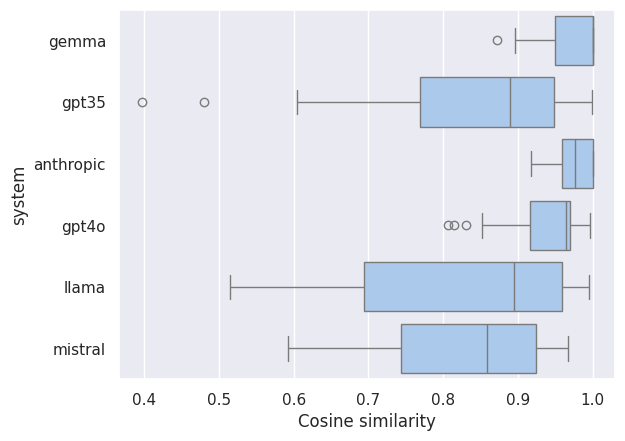

In [31]:
import pandas as pd
import seaborn as sns

jaccard = pd.DataFrame({"system": all_sys, "Cosine similarity": all_scores})
sns.boxplot(data=jaccard, x="Cosine similarity", y="system")
# sns.violinplot(data=jaccard, x="Cosine similarity", y="system", split=True, inner="quart")
sns.set_style("darkgrid")
#g = sns.violinplot(data=jaccard, x="Jaccard Similarity", y="system", inner="point")
#g.set(xlim=(0, 1))

Cosine similarity for two different LLMs for the same prompt

In [26]:
all_taus2 = []
all_sys2 = []

def def_tensor():
    return torch.tensor([])

for prompt in prompts: # per prompt
    sim_llm = defaultdict(def_tensor)
    df_prmp = df[df['prompt']==prompt]

    for system in ['gemma', 'anthropic', 'gpt35', 'gpt4o', 'llama', 'mistral']: # per system
        df_sys = df_prmp[df_prmp['model']==system]
        res_docs = '' # a list of documents or responses for the same prompt
        for row in range(len(df_sys.index)):
            res_doc = ''
            for rec in ['rec_reasons1', 'rec_reasons2', 'rec_reasons3', 'rec_reasons4', 'rec_reasons5']:
                reason = df_sys.iloc[row][rec]
                reason = reason.replace('\\n','')
                # preprocess text (rm punctuations)
                reason = reason.lower()
                # append to list
                res_doc+=reason # a response
            res_docs+=res_doc
        sim_llm[system] = model.encode(res_docs, convert_to_tensor=True)
    # print(sim_llm.keys())

    for (sys1, sys2) in combinations(['gemma', 'anthropic', 'gpt35', 'gpt4o', 'llama', 'mistral'], 2):
        sim = util.pytorch_cos_sim(sim_llm[sys1], sim_llm[sys2])

        print('the cosine similariy of {} and {} is {}'.format(sys1, sys2, sim.item()))
        all_sys2.append(sys1)
        all_taus2.append(sim.item())
        all_sys2.append(sys2)
        all_taus2.append(sim.item())

the cosine similariy of gemma and anthropic is 0.8163360953330994
the cosine similariy of gemma and gpt35 is 0.7458125948905945
the cosine similariy of gemma and gpt4o is 0.8335733413696289
the cosine similariy of gemma and llama is 0.8406203985214233
the cosine similariy of gemma and mistral is 0.8627434372901917
the cosine similariy of anthropic and gpt35 is 0.8098746538162231
the cosine similariy of anthropic and gpt4o is 0.8533725738525391
the cosine similariy of anthropic and llama is 0.8502342700958252
the cosine similariy of anthropic and mistral is 0.8887097835540771
the cosine similariy of gpt35 and gpt4o is 0.8250156044960022
the cosine similariy of gpt35 and llama is 0.861172080039978
the cosine similariy of gpt35 and mistral is 0.7870410680770874
the cosine similariy of gpt4o and llama is 0.891985297203064
the cosine similariy of gpt4o and mistral is 0.8378344178199768
the cosine similariy of llama and mistral is 0.8601541519165039
the cosine similariy of gemma and anthropi

<Axes: xlabel='Cosine similarity', ylabel='system'>

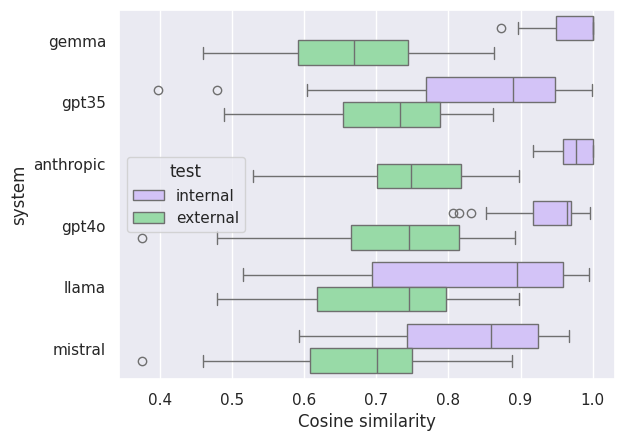

In [29]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid", palette="pastel")
jaccard = pd.DataFrame({"system": all_sys+all_sys2, "Cosine similarity": all_scores+all_taus2, "test": ['internal']*len(all_sys)+['external']*len(all_sys2)})
sns.boxplot(data=jaccard, x="Cosine similarity", y="system", hue="test", palette=["m", "g"])
#sns.violinplot(data=jaccard, x="Jaccard similarity", y="system", split=True, inner="quart")
#sns.set_style("darkgrid")
#g = sns.violinplot(data=jaccard, x="Jaccard Similarity", y="system", inner="point")
#g.set(xlim=(0, 1))